In [1]:
import polars as pl
import numpy as np
from numba import njit, guvectorize
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def pandas_sma(series, window):
    return series.rolling(window).mean()

In [3]:
def polars_sma(series, window):
    return series.rolling_mean(window_size=window)

In [4]:
# https://numba.readthedocs.io/en/stable/user/vectorize.html?highlight=guvectorize#the-guvectorize-decorator
# https://numba.readthedocs.io/en/stable/user/examples.html?highlight=moving%20average#moving-average

@guvectorize(['void(float64[:], intp[:], float64[:])'],

             '(n),()->(n)')

def move_mean(a, window_arr, out):
    window_width = window_arr[0]
    asum = 0.0
    count = 0

    for i in range(window_width):
        asum += a[i]
        count += 1
        out[i] = asum / count

    for i in range(window_width, len(a)):
        asum += a[i] - a[i - window_width]
        out[i] = asum / count

In [5]:
book = pl.read_csv('book.csv')
book = book[["timestamp", "asks[0].price", "bids[0].price"]]
book = book.with_columns(
    mid_price_future = (book["asks[0].price"] + book["bids[0].price"]) * 0.5
).drop(["asks[0].price", "bids[0].price"]).set_sorted("timestamp")

In [6]:
book_spot = pl.read_csv("book.spot.csv")
book_spot = book_spot[["timestamp", "asks[0].price", "bids[0].price"]]
book_spot = book_spot.with_columns(
    mid_price_spot = (book_spot["asks[0].price"] + book_spot["bids[0].price"]) * 0.5
).drop(["asks[0].price", "bids[0].price"]).set_sorted("timestamp")

In [7]:
merged = book_spot.join_asof(book, on="timestamp", strategy="nearest").drop("timestamp")

In [8]:
differences = (merged.with_columns(
    difference = (merged["mid_price_spot"] / merged["mid_price_future"] - 1) * 10000
).drop(["mid_price_spot", "mid_price_future"])).to_numpy().flatten()

In [9]:
def calcualate_timings_windows(differences, windows):
    numba_timings = []
    polars_timings = []
    pandas_timings = []
    for window in windows:
        differences_polars = pl.Series(differences)
        differences_pd = pd.Series(differences)

        out = np.zeros(differences.shape)
        time_numba = %timeit -n 5 -r 5 -o move_mean(differences, window, out)
        time_polars = %timeit -n 5 -r 5 -o out_pandas = polars_sma(differences_polars, window)
        time_pandas = %timeit -n 5 -r 5 -o out_pandas = pandas_sma(differences_pd, window)

        numba_timings.append(time_numba.average)
        polars_timings.append(time_polars.average)
        pandas_timings.append(time_pandas.average)

    numba_timings = np.array(numba_timings)
    polars_timings = np.array(polars_timings)
    pandas_timings = np.array(pandas_timings)

    return numba_timings, polars_timings, pandas_timings

In [10]:
windows = 10 ** np.arange(2, 6, 1)
numba_timings, polars_timings, pandas_timings= calcualate_timings_windows(differences, [100, 1000, 10000, 100000])

4.23 ms ± 651 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
12.7 ms ± 526 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
31.5 ms ± 902 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
3.4 ms ± 318 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
12.3 ms ± 160 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
31.3 ms ± 379 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
3.27 ms ± 356 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
12.5 ms ± 106 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
32.5 ms ± 1.82 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
3.4 ms ± 52.5 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
12.7 ms ± 128 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
32.1 ms ± 334 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


Text(0.5, 1.0, 'Numba vs Polars vs Pandas')

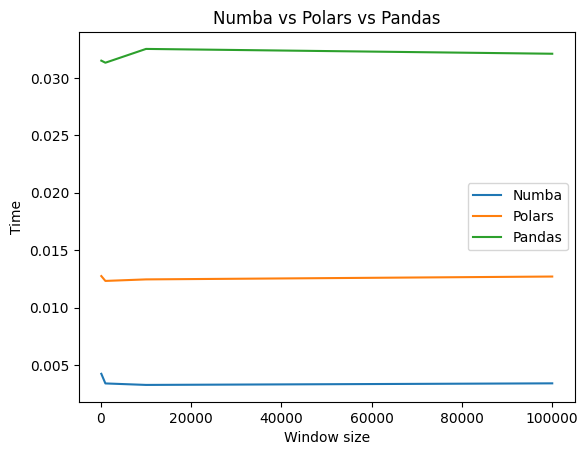

In [11]:
plt.plot(windows, numba_timings, label = 'Numba')
plt.plot(windows, polars_timings, label = 'Polars')
plt.plot(windows, pandas_timings, label = 'Pandas')
plt.xlabel("Window size")
plt.ylabel("Time")
plt.legend()
plt.title("Numba vs Polars vs Pandas")